# Neural network

### Data

In [5]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Importing the dataset
df = pd.read_csv('creditcard.csv')
df = df.drop(['Time'], axis=1)
df.reset_index(drop=True, inplace=True)

# Feature Scaling
X = (df.drop(['Class'], axis=1).values)
medians = np.median(X)
q1 = np.quantile(X, 0.25)
q3 = np.quantile(X, 0.75)
iqr = np.where(q3 - q1 == 0, 0.0001, q3 - q1)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split((df.drop(['Class'], axis=1) - medians) / iqr, df['Class'], test_size = 0.2, random_state = 1)


### Model

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight

indput_d = X_train.shape[1]

# Compute class weights
class_weights = class_weight.compute_class_weight( class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Define the model
model = keras.Sequential([
    layers.Dense(indput_d, activation='relu', input_shape=[indput_d]),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax'),
])

# Compile the model
model.compile(
    optimizer='RMSprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
epochs = 10
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# Train the model
H = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    class_weight=class_weights_dict,
    callbacks=[callback],
    shuffle=True
)

Epoch 1/10
5697/5697 - 17s - loss: 19.7912 - accuracy: 0.9937 - val_loss: 0.0909 - val_accuracy: 0.9991 - 17s/epoch - 3ms/step
Epoch 2/10
5697/5697 - 16s - loss: 18.7945 - accuracy: 0.9956 - val_loss: 0.0817 - val_accuracy: 0.9990 - 16s/epoch - 3ms/step
Epoch 3/10
5697/5697 - 16s - loss: 14.9249 - accuracy: 0.9952 - val_loss: 0.0545 - val_accuracy: 0.9991 - 16s/epoch - 3ms/step
Epoch 4/10
5697/5697 - 17s - loss: 11.5144 - accuracy: 0.9952 - val_loss: 0.0738 - val_accuracy: 0.9991 - 17s/epoch - 3ms/step
Epoch 5/10
5697/5697 - 17s - loss: 13.9091 - accuracy: 0.9952 - val_loss: 0.2086 - val_accuracy: 0.9991 - 17s/epoch - 3ms/step


In [7]:
# Classification report to evaluate the model
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=-1)
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=['Not Fraud', 'Fraud']))

1781/1781 [==============================] - 2s 1ms/step


,Not Fraud,Fraud,accuracy,macro avg,weighted avg
precision,0.999525,0.800000,0.999263,0.899763,0.999221
recall,0.999736,0.689655,0.999263,0.844696,0.999263
f1-score,0.999631,0.740741,0.999263,0.870186,0.999235
support,56875.000000,87.000000,0.999263,56962.000000,56962.000000


We got a f1-score of around 0.87, which is as good as the ML models.

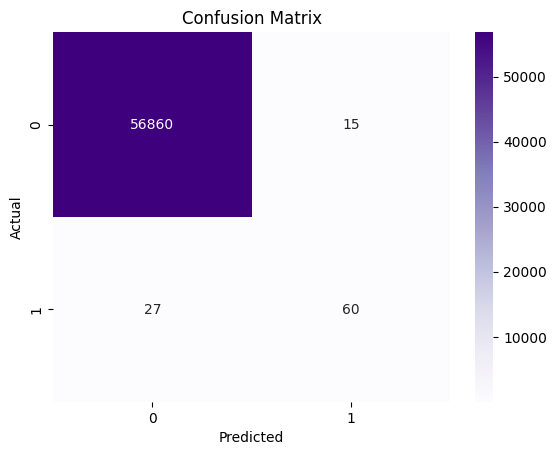

In [8]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = pd.crosstab(y_test.T, y_pred.T, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix')
plt.savefig('ressources/plots/confusion_matrix_dl.png')